# Capstone Project: Part 4 Natural Language Processing Classification Models

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

In [2]:
train=pd.read_csv('../Data/processed_data/nlp_train.csv')
test=pd.read_csv('../Data/processed_data/nlp_test.csv')

In [3]:
# dropping null values after nlp in train set
train.dropna(inplace=True)

In [4]:
# dropping null values after nlp in testing set
test.dropna(inplace=True)

## Vectorizing Hyperparameters

## NonViolent Features

In [5]:
# NonViolent Features
X_train=train.loc[train['violence']==0, 'lemmatized_tokenized_description']
y_train=train.loc[train['violence']==0, 'violence']
X_test=test.loc[test['violence']==0, 'lemmatized_tokenized_description']
y_test=test.loc[test['violence']==0, 'violence']
cv=CountVectorizer(stop_words='english', max_df=0.95, min_df=0.05, max_features=100, ngram_range=(1,5))
cv.fit(X_train)
X1_train = cv.transform(X_train)
X1_train_df = pd.DataFrame(X1_train.toarray(), columns = cv.get_feature_names())

In [6]:
X1_train_df.sum().sort_values(ascending=False).head(20)

wa             1738
death           429
trans           422
died            402
woman           346
suicide         343
body            299
said            293
year            265
police          261
people          258
life            254
family          238
friend          221
day             183
victim          182
transgender     179
according       165
trans woman     162
ha              158
dtype: int64

## Violent Features

In [7]:
# Violent Features
X_train=train.loc[train['violence']==1, 'lemmatized_tokenized_description']
y_train=train.loc[train['violence']==1, 'violence']
X_test=test.loc[test['violence']==1, 'lemmatized_tokenized_description']
y_test=test.loc[test['violence']==1, 'violence']
cv=CountVectorizer(stop_words='english', max_df=0.95, min_df=0.05, max_features=100, ngram_range=(1,5))
cv.fit(X_train)
X2_train = cv.transform(X_train)
X2_train_df = pd.DataFrame(X2_train.toarray(), columns = cv.get_feature_names())

In [8]:
X2_train_df.sum().sort_values(ascending=False).head(20)

wa             9517
police         2241
woman          2038
victim         2001
body           1987
trans          1796
shot           1510
year           1345
according      1143
trans woman    1131
murder         1097
said           1017
death           987
crime           940
body wa         891
wa shot         844
killed          827
old             826
year old        798
died            765
dtype: int64

## Pipeline with Count Vectorizer Running Into A Multinomial Naive Bayes

In [9]:
# defining X and y and splitting into traintest sets
X_train=train['lemmatized_tokenized_description']
y_train=train['violence']
X_test=test['lemmatized_tokenized_description']
y_test=test['violence']

## Baseline 

In [10]:
y_train.value_counts(normalize=True)

1    0.857843
0    0.142157
Name: violence, dtype: float64

Baseline value is 85.8% because there were much more posts classified as violent in our dataframe. Predicting that every death will be a violent one will be 85.8% accurate.

In [11]:
# setting up pipeline and its parameters
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', ngram_range = (1,3))),
    ('mnb', MultinomialNB())
])
bs_params = {
    'cv__max_features':Integer(1,10000)
}

In [12]:
# setting and fitting up bayessearchcv
bs = BayesSearchCV(estimator = pipe,
                     search_spaces = bs_params,
                     scoring = 'f1_weighted',
                     n_iter = 50,
                     cv = 5,
                     verbose = 1, n_jobs=-1,
                     random_state=42)
bs.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('cv',
                                         CountVectorizer(ngram_range=(1, 3),
                                                         stop_words='english')),
                                        ('mnb', MultinomialNB())]),
              n_jobs=-1, random_state=42, scoring='f1_weighted',
              search_spaces={'cv__max_features': Integer(low=1, high=10000, prior='uniform', transform='normalize')},
              verbose=1)

In [13]:
bs.best_score_

0.9343590377799952

In [14]:
bs.best_params_

OrderedDict([('cv__max_features', 9382)])

In [15]:
# getting predictions and saving confusion matrix values
preds = bs.predict(X_test)
tn,fp,fn,tp=confusion_matrix(y_test,preds).ravel()

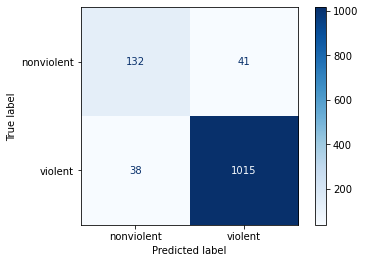

In [16]:
# viewing confusion matrix 
plot_confusion_matrix(bs, X_test,y_test,cmap='Blues', display_labels=['nonviolent','violent']);
# plt.savefig('confusionbs')

n: The above image shows the confusion matrix generated by BayesSearchCV running a pipeline with a CountVectorizer and MultiNomialNB() with sorted categories with amounts indicated with a number and by the color scale.

In [17]:
# calculating specificity 
spec=tn/(tn+fp)
print(f'Specificity is {spec}')

Specificity is 0.7630057803468208


In [18]:
# calculating precision 
precision=tp/(tp+fp)
print(f'Precision is {precision}')

Precision is 0.9611742424242424


In [19]:
print(classification_report(y_test, preds, target_names=['nonviolent', 'violent'], digits=3))

              precision    recall  f1-score   support

  nonviolent      0.776     0.763     0.770       173
     violent      0.961     0.964     0.963      1053

    accuracy                          0.936      1226
   macro avg      0.869     0.863     0.866      1226
weighted avg      0.935     0.936     0.935      1226



##  Count Vectorizer

In [20]:
# transforming X_train using TfidVectorizer
cv = CountVectorizer(stop_words='english',ngram_range=(1,3), max_features= 9382)
Z_train=cv.fit_transform(X_train)


In [21]:
# looking at vocabulary
cv.vocabulary_

{'maria': 4906,
 'wa': 8459,
 'shot': 7183,
 'assailant': 862,
 'motorcycle': 5232,
 'young': 9335,
 'transsexual': 8089,
 'girl': 3410,
 'identified': 3865,
 'eduarda': 2827,
 'murdered': 5318,
 'gunshot': 3506,
 'parque': 5766,
 'municipality': 5274,
 'located': 4720,
 'km': 4410,
 'teresina': 7777,
 'northern': 5493,
 'region': 6475,
 'piauí': 5952,
 'crime': 2065,
 'took': 7933,
 'place': 5972,
 '20': 107,
 '30': 213,
 'pm': 6012,
 'thursday': 7858,
 '24': 177,
 'according': 390,
 'popular': 6118,
 'information': 3991,
 'men': 5026,
 'arrived': 816,
 'passenger': 5790,
 'victim': 8319,
 'died': 2541,
 'scene': 6922,
 'wa shot': 8871,
 'assailant motorcycle': 863,
 'young transsexual': 9347,
 'transsexual girl': 8090,
 'girl identified': 3411,
 'eduarda wa': 2828,
 'wa murdered': 8775,
 'crime took': 2085,
 'took place': 7938,
 '20 30': 110,
 '30 pm': 217,
 'pm thursday': 6013,
 'men arrived': 5030,
 'arrived motorcycle': 819,
 'shot victim': 7245,
 'victim died': 8336,
 'died scene

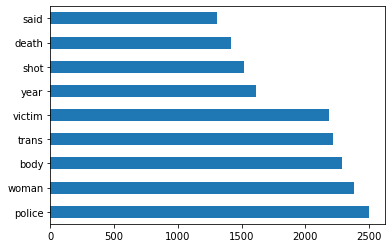

In [22]:
# Convert X_train into a DataFrame.
Z_train_df = pd.DataFrame(Z_train.toarray(), columns=cv.get_feature_names())

# plot top occuring words
Z_train_df.sum().sort_values(ascending=False)[1:10].plot(kind='barh');

## Pipeline with TFIDF Vectorizer Running into a Multinomial Naive Bayes

In [23]:
# defining X and y and splitting into traintest sets
X_train=train['lemmatized_tokenized_description']
y_train=train['violence']
X_test=test['lemmatized_tokenized_description']
y_test=test['violence']

In [24]:
# setting up pipeline and its parameters
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', ngram_range = (1,3))),
    ('mnb', MultinomialNB())
])
bs_params2 = {
    'tvec__max_features':Integer(1,20000)}

In [25]:
# setting and fitting up bayessearchcv
bs2 = BayesSearchCV(estimator = pipe2,
                     search_spaces = bs_params2,
                     scoring = 'f1_weighted',
                     n_iter = 50,
                     cv = 5,
                     verbose = 1, n_jobs=-1,
                     random_state=42)
bs2.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('tvec',
                                         TfidfVectorizer(ngram_range=(1, 3),
                                                         stop_words='english')),
                                        ('mnb', MultinomialNB())]),
              n_jobs=-1, random_state=42, scoring='f1_weighted',
              search_spaces={'tvec__max_features': Integer(low=1, high=20000, prior='uniform', transform='normalize')},
              verbose=1)

In [26]:
bs2.best_score_

0.9245837950464164

In [27]:
bs2.best_params_

OrderedDict([('tvec__max_features', 1485)])

In [28]:
# getting predictions and saving confusion matrix values
preds = bs2.predict(X_test)
tn,fp,fn,tp=confusion_matrix(y_test,preds).ravel()

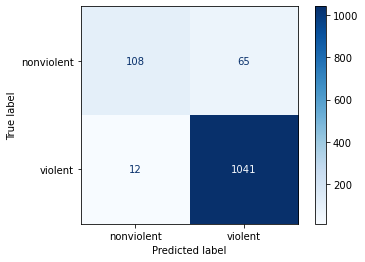

In [29]:
# viewing confusion matrix 
plot_confusion_matrix(bs2, X_test,y_test,cmap='Blues', display_labels=['nonviolent','violent']);
# plt.savefig('confusionbs2')

n: The above image shows the confusion matrix generated by BayesSearchCV running a pipeline with a TfidfVectorizer and MultiNomialNB() with sorted categories with amounts indicated with a number and by the color scale.

In [30]:
# calculating specificity 
spec=tn/(tn+fp)
print(f'Specificity is {spec}')

Specificity is 0.6242774566473989


In [31]:
# calculating precision 
precision=tp/(tp+fp)
print(f'Precision is {precision}')

Precision is 0.9412296564195298


In [32]:
print(classification_report(y_test, preds, target_names=['nonviolent', 'violent'], digits=3))

              precision    recall  f1-score   support

  nonviolent      0.900     0.624     0.737       173
     violent      0.941     0.989     0.964      1053

    accuracy                          0.937      1226
   macro avg      0.921     0.806     0.851      1226
weighted avg      0.935     0.937     0.932      1226



##  Tfidf Vectorizer

In [33]:
# transforming X_train using TfidVectorizer
tvec = TfidfVectorizer(stop_words='english',ngram_range=(1,3), max_features= 1257)
Z_train=tvec.fit_transform(X_train)


In [34]:
# looking at vocabulary
tvec.vocabulary_

{'maria': 666,
 'wa': 1149,
 'shot': 961,
 'assailant': 153,
 'motorcycle': 707,
 'young': 1250,
 'transsexual': 1100,
 'girl': 477,
 'identified': 537,
 'murdered': 717,
 'gunshot': 490,
 'municipality': 712,
 'located': 642,
 'northern': 738,
 'region': 869,
 'crime': 308,
 'took': 1070,
 'place': 790,
 '20': 25,
 '30': 65,
 'pm': 793,
 'thursday': 1063,
 '24': 51,
 'according': 94,
 'popular': 809,
 'information': 551,
 'men': 678,
 'arrived': 146,
 'victim': 1133,
 'died': 362,
 'scene': 932,
 'wa shot': 1183,
 'wa murdered': 1169,
 'crime took': 311,
 'took place': 1072,
 'victim died': 1136,
 'died scene': 366,
 'crime took place': 312,
 'neighbour': 730,
 'body': 204,
 'man': 661,
 'witness': 1217,
 'killing': 592,
 'body victim': 209,
 'sitting': 978,
 'car': 238,
 'having': 507,
 'conversation': 297,
 'trans': 1078,
 'believed': 189,
 'hate': 504,
 'killer': 591,
 'year': 1241,
 'later': 603,
 '17th': 18,
 'transgender': 1089,
 'day': 327,
 'police': 795,
 'resident': 891,
 'a

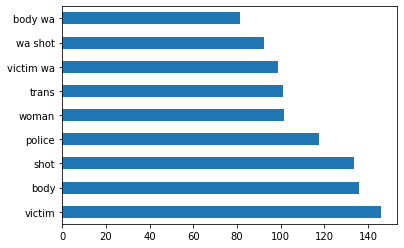

In [35]:
# Convert X_train into a DataFrame.
Z_train_df = pd.DataFrame(Z_train.toarray(), columns=tvec.get_feature_names())

# plot top occuring words
Z_train_df.sum().sort_values(ascending=False)[1:10].plot(kind='barh');

### Logistic Regression Model Scoring

In [36]:
# instantiate and fit model
lr = LogisticRegression(solver = 'lbfgs', max_iter=5000)
lr.fit(Z_train_df, y_train)
# scoring train data model
lr.score(Z_train,y_train)

0.9474789915966386

In [37]:
cross_val_score(lr, Z_train_df, y_train, cv=5).mean()

0.9306743169265062

In [38]:
# transform test
Z_test=tvec.transform(X_test)

In [39]:
# creating Z_test DataFrame
Z_test_df = pd.DataFrame(Z_test.toarray(), columns=tvec.get_feature_names())


In [40]:
# scoring test data model
lr.score(Z_test,y_test)

0.9314845024469821

In [41]:
# getting predictions and saving confusion matrix values
preds = lr.predict(Z_test)
tn,fp,fn,tp=confusion_matrix(y_test,preds).ravel()

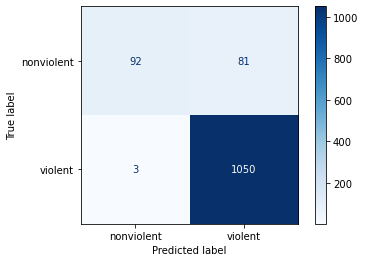

In [42]:
# viewing confusion matrix 
plot_confusion_matrix(lr, Z_test,y_test,cmap='Blues', display_labels=['nonviolent','violent']);
# plt.savefig('confusionlr')

n: The above image shows the confusion matrix generated by performing a Logistic Regression with TfidfVectorizer with sorted categories with amounts indicated with a number and by the color scale.

In [43]:
# calculating specificity 
spec=tn/(tn+fp)
print(f'Specificity is {spec}')

Specificity is 0.5317919075144508


In [44]:
# calculating precision 
precision=tp/(tp+fp)
print(f'Precision is {precision}')

Precision is 0.9283819628647215


In [45]:
print(classification_report(y_test, preds, target_names=['nonviolent', 'violent'], digits=3))

              precision    recall  f1-score   support

  nonviolent      0.968     0.532     0.687       173
     violent      0.928     0.997     0.962      1053

    accuracy                          0.931      1226
   macro avg      0.948     0.764     0.824      1226
weighted avg      0.934     0.931     0.923      1226



### Logistic Regression Model Features Strength

In [46]:
Z_train_df.sum().sort_values(ascending=False).head(20)

wa             356.506453
victim         145.979420
body           135.717455
shot           133.682338
police         117.784073
woman          101.421422
trans          101.084369
victim wa       98.794518
wa shot         92.259231
body wa         81.524806
died            81.427974
death           81.008159
year            71.349562
according       70.235334
trans woman     69.068428
dead            66.973469
killed          66.774196
murder          65.808111
said            64.170918
head            64.005767
dtype: float64

In [47]:
Z_test_df.sum().sort_values(ascending=False).head(20)

wa             157.016053
victim          62.436530
body            57.172384
shot            55.780284
police          54.241758
trans           48.702412
woman           47.229570
victim wa       44.573373
wa shot         39.603799
body wa         37.101568
death           36.571229
year            31.523863
died            31.332817
trans woman     30.683101
stabbed         30.671900
said            30.483675
dead            30.222276
killed          30.204709
according       29.104884
murder          28.599660
dtype: float64

### Random Forest Classifier Model Scoring

In [48]:
# instantiate and fit model
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=None, 
                            max_features='log2', 
                            min_samples_split=50)
rf.fit(Z_train_df, y_train)
# scoring train model data
rf.score(Z_train, y_train)

0.9565826330532213

In [49]:
cross_val_score(rf,Z_train_df,y_train,cv=5).mean()

0.9173667838291305

In [50]:
rf.score(Z_test,y_test)

0.9094616639477977

In [51]:
# getting predictions and saving confusion matrix values
preds = rf.predict(Z_test)
tn,fp,fn,tp=confusion_matrix(y_test,preds).ravel()

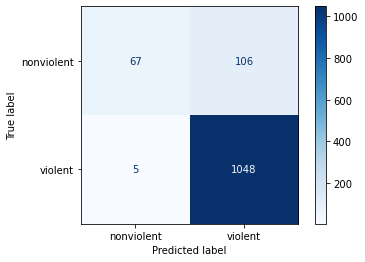

In [52]:
# viewing confusion matrix 
plot_confusion_matrix(rf, Z_test,y_test,cmap='Blues', display_labels=['nonviolent','violent']);
# plt.savefig('confusionrf')

n: The above image shows the confusion matrix generated by performing a Random Forest Regression with TfidfVectorizer with sorted categories with amounts indicated with a number and by the color scale.

In [53]:
# calculating specificity 
spec=tn/(tn+fp)
print(f'Specificity is {spec}')

Specificity is 0.3872832369942196


In [54]:
# calculating precision 
precision=tp/(tp+fp)
print(f'Precision is {precision}')

Precision is 0.9081455805892548


In [55]:
print(classification_report(y_test, preds, target_names=['nonviolent', 'violent'], digits=3))

              precision    recall  f1-score   support

  nonviolent      0.931     0.387     0.547       173
     violent      0.908     0.995     0.950      1053

    accuracy                          0.909      1226
   macro avg      0.919     0.691     0.748      1226
weighted avg      0.911     0.909     0.893      1226



### Random Forest Model Features Strength

In [56]:
Z_train_df.sum().sort_values(ascending=False).head(20)

wa             356.506453
victim         145.979420
body           135.717455
shot           133.682338
police         117.784073
woman          101.421422
trans          101.084369
victim wa       98.794518
wa shot         92.259231
body wa         81.524806
died            81.427974
death           81.008159
year            71.349562
according       70.235334
trans woman     69.068428
dead            66.973469
killed          66.774196
murder          65.808111
said            64.170918
head            64.005767
dtype: float64

In [57]:
Z_test_df.sum().sort_values(ascending=False).head(20)

wa             157.016053
victim          62.436530
body            57.172384
shot            55.780284
police          54.241758
trans           48.702412
woman           47.229570
victim wa       44.573373
wa shot         39.603799
body wa         37.101568
death           36.571229
year            31.523863
died            31.332817
trans woman     30.683101
stabbed         30.671900
said            30.483675
dead            30.222276
killed          30.204709
according       29.104884
murder          28.599660
dtype: float64

## Feature Plots

In [58]:
# getting the most positively correlated and negatively correlated features 
# which would correspond to the violent and nonviolent deaths 
best_features = sorted(list(zip(lr.coef_[0], tvec.get_feature_names())))
best_features[:10] + best_features[-10:]

[(-5.760175211459286, 'suicide'),
 (-3.1156376010172036, 'died suicide'),
 (-3.1001939107327665, 'wa person'),
 (-2.869502872457166, 'died'),
 (-2.1659301231223016, 'procedure'),
 (-1.9589293929934692, 'silicone'),
 (-1.8622523819148609, 'cause'),
 (-1.6360380409626953, 'cause death'),
 (-1.6236301278206962, 'death'),
 (-1.6089288692659356, 'life'),
 (1.8309931518231881, 'beaten'),
 (1.8536020834044553, 'wound'),
 (1.9785374402291562, 'crime'),
 (2.0778625283321226, 'murdered'),
 (2.339826106647143, 'head'),
 (2.4364474803367373, 'killed'),
 (2.6427191824679377, 'wa shot'),
 (2.6716942378466264, 'stabbed'),
 (2.8794275364499318, 'murder'),
 (4.1789985570822425, 'shot')]

In [59]:
# making feature list for nonviolent deaths and converting to dataframe
nonviolent_features = []
for a,b in best_features[:20]:
    features = {}
    features['feature'] = b
    features['corr_coef_'] = a
    nonviolent_features.append(features)
nonviolent_df = pd.DataFrame(nonviolent_features)
nonviolent_df.head(20)

,feature,corr_coef_
0,suicide,-5.760175
1,died suicide,-3.115638
2,wa person,-3.100194
3,died,-2.869503
4,procedure,-2.165930
5,silicone,-1.958929
6,cause,-1.862252
7,cause death,-1.636038
8,death,-1.623630
9,life,-1.608929


In [60]:
# making feature list for nonviolent deaths and converting to dataframe
violent_features = []
for a,b in best_features[:-21:-1]:
    features = {}
    features['feature'] = b
    features['corr_coef_'] = a
    violent_features.append(features)
violent_df = pd.DataFrame(violent_features)
violent_df.head(20)

,feature,corr_coef_
0,shot,4.178999
1,murder,2.879428
2,stabbed,2.671694
3,wa shot,2.642719
4,killed,2.436447
5,head,2.339826
6,murdered,2.077863
7,crime,1.978537
8,wound,1.853602
9,beaten,1.830993


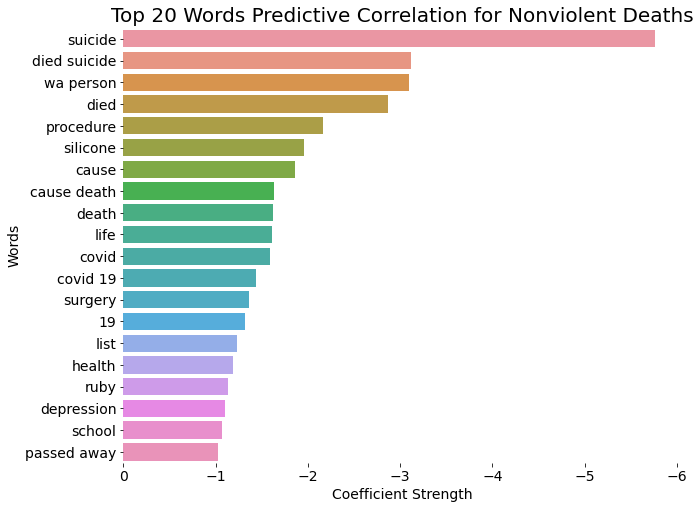

In [61]:
# plotting features with strongest correlations for nonviolent deaths 
plt.figure(figsize=(10,8))
sns.barplot(data=nonviolent_df, x='corr_coef_', y='feature').invert_xaxis()
plt.xlabel('Coefficient Strength', size=14)
plt.ylabel('Words', size=14)
plt.yticks(size=14)
plt.xticks(size=14)
plt.title('Top 20 Words Predictive Correlation for Nonviolent Deaths', size=20)
sns.despine(left=True, bottom=True)
# plt.savefig('20wordsnonviolentdeaths');

n: The above image shows the 20 phrases that have the highest predictive correlation for nonviolent deaths.  The features were determined using TfidfVectorizer with Logistic Regression.

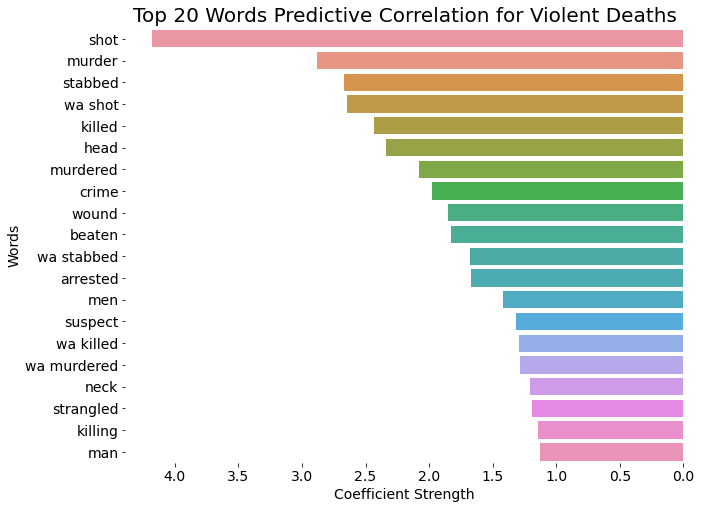

In [62]:
# plotting features with strongest correlations for violent deaths 
plt.figure(figsize=(10,8))
sns.barplot(data=violent_df, x='corr_coef_', y='feature').invert_xaxis()
plt.xlabel('Coefficient Strength', size=14)
plt.ylabel('Words', size=14)
plt.yticks(size=14)
plt.xticks(size=14)
plt.title('Top 20 Words Predictive Correlation for Violent Deaths', size=20)
sns.despine(left=True, bottom=True)
# plt.savefig('20wordsviolentdeaths');

n: The above image shows the 20 phrases that have the highest predictive correlation for violent deaths.  The features were determined using TfidfVectorizer with Logistic Regression.